<a href="https://colab.research.google.com/github/Dharmin-Shah/Dog-Breed-Image-Classifier/blob/main/Dog_Breed_Classifier_(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Dog Breed Classifier using PyTorch </b>
---


## <b>Introduction</b>

This project is an image classifier application for dog images. We try to build a classifier that can predict the breed of the dog from the image provided.

For this project we will be using <b>PyTorch</b>. We would also be using <b>Transfer Learning</b> to achieve the desired outcome.

> Let's start with the imports

In [1]:
import os
import numpy as np
from google.colab import files

In [2]:
import torch
from torchvision import datasets
from PIL import ImageFile
import torchvision.transforms as transforms

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request

In [5]:
# Setting flag for GPU availability
use_cuda = torch.cuda.is_available()
print(use_cuda)
# Allow all types of images to be used
ImageFile.LOAD_TRUNCATED_IMAGES = True

True


## Fetching the Data

> We will be using a function to fetch the dog images from Kaggle.

In [6]:
def kaggle_dataset_fetch(kgdata):
  '''
  This function will dowanload and unzip the required dataset.
  Initial lines of code are necessary to install the kaggle api and use the
  kaggle.json file to link the dataset.

  ARGS: Kaggle dataset name that needs to be downloaded. This can be obtained by 
         using the 'Copy API Command' from dataset's page. The last argument in the
         command is the dataset name.
  '''

  #Installing kaggle api
  os.system("pip install -q kaggle")

  # Remove any exiting kaggle.json file
  #os.system("rm -f kaggle.json")
  
  # Cleanup
  os.system("rm -r -f ~/.kaggle/")
  os.system("mkdir ~/.kaggle/")
  
  # Uploading the kaggle.json file
  uploaded = files.upload()
  
  if uploaded.get("kaggle.json") == None:
    raise Exception("kaggle.json was not found. Please upload again")
  
  # Granting permissions
  os.system("cp kaggle.json ~/.kaggle/")
  os.system("chmod 600 /root/.kaggle/kaggle.json")

  #Download voice dataset for testing
  print(f"kaggle datasets download -d {kgdata}")
  os.system(f"kaggle datasets download -d {kgdata}")

  #Unzipping the dataset
  z = os.popen("ls *.zip").read()
  os.system(f"unzip {z}")
  
  #Removing zip file once we unzip it
  os.system(f"rm -f {z}")

In [7]:
kaggle_dataset_fetch('dharminshah/dogbreed')

Saving kaggle.json to kaggle.json
kaggle datasets download -d dharminshah/dogbreed


## Preprocessing the images 

>Prepare transformations for train and test data.

In [8]:
#Transformations for training dataset
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5,0.5,0.5],
                                                     [0.5,0.5,0.5])])

#Transformations for testing dataset
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])


## Creating Datasets and Loaders

> Creating train, test and validation datasets and creating their respective loaders.

In [9]:
#Creating the datasets
train_data = datasets.ImageFolder('dogImages/train', transform=train_transforms)
valid_data = datasets.ImageFolder('dogImages/valid', transform=test_transforms)
test_data = datasets.ImageFolder('dogImages/test', transform=test_transforms)

#Creating loaders
loaders_scratch = {'train' : torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True),
'test' : torch.utils.data.DataLoader(test_data, batch_size=32),
'valid' : torch.utils.data.DataLoader(valid_data, batch_size=32)}

> Let's have a look at some images with their classes.

In [10]:
train_data.imgs[45]

('dogImages/train/001.Affenpinscher/Affenpinscher_00057.jpg', 0)

001.Affenpinscher


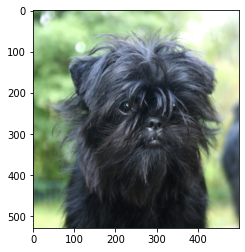

003.Airedale_terrier


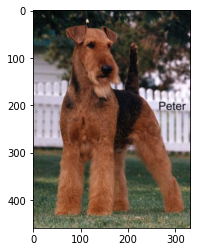

008.American_staffordshire_terrier


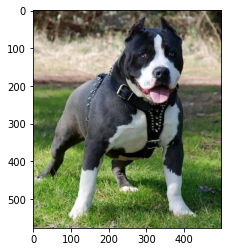

011.Australian_cattle_dog


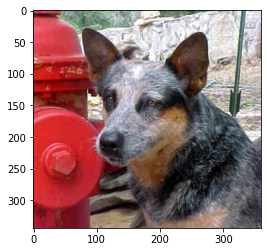

017.Bearded_collie


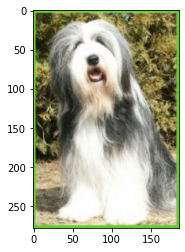

In [11]:
idx = [45,160,450,600,1001]

for i in idx:
  print(train_data.classes[train_data.imgs[i][1]])
  plt.imshow(Image.open(train_data.imgs[i][0]))
  plt.show()

## Creating the Model

> We now create the CNN model that we will train for our application.

> We define a class to encapsulate the different layers.

In [12]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        
        self.conv1 = nn.Conv2d(3,32,3,padding=1) # in_channels = 3, kernel_size=3, out_channels=32
        
        self.conv2 = nn.Conv2d(32,64,3,padding=1) #in_channels = 32, kernel_size=3, out_channels=64
        
        self.conv3 = nn.Conv2d(64,128,3,padding=1) #in_channels = 64, kernel_size=3, out_channels=128

        self.pool = nn.MaxPool2d(2,2)
        
        # After applying 3 max pool functions, the size of the image is reduced to 28x28
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) #Flattening Layer (28,28=hieght and width params) and 1024 neurons
        
        self.fc2 = nn.Linear(512,133) #133 Classes
        
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        #Changing the shape of tensor, to flatten it for linear layers
        x = x.view(-1, 128*28*28)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
                
        return x

##Instantiate the model

> We create the model by creating the object of Net class.

In [13]:
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [14]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


##Training the model

> Once the model is created, we need to move on to training the model.

###Setup the loss function and optimizer

> We first need to setup the loss function and the optimizer. <br>
For our project, we are using <b>CrossEntropyLoss</b>, as they are used for classification problems.<br>
The optimizer we are using is the <b>Adam</b> optimizer.

In [15]:
#Loss function
criterion_scratch = nn.CrossEntropyLoss()

#Optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.01)

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''
    This function will train the model for the specified epochs.
    '''
   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    val_count_loss = 0
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model 
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            #find the loss and update the model parameters accordingly
            #record the average training loss, using the below formula:
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        
        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            #update the average validation loss
            output = model(data)
            
            loss = criterion(output,target)
            
            valid_loss += loss.item()*data.size(0)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        
        #Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            val_count_loss = 0
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            val_count_loss +=1

        
        if val_count_loss >= 7:
          print('Early Stopping because validation loss has not decreased in last 7 epochs')
          break

        
    # return trained model
    return model

###Training the model

In [ ]:
# train the model
model_scratch = train(80, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.886652 	Validation Loss: 4078.105592
Validation loss decreased (inf --> 4078.105592).  Saving model ...
Epoch: 2 	Training Loss: 4.874135 	Validation Loss: 4071.491686
Validation loss decreased (4078.105592 --> 4071.491686).  Saving model ...
Epoch: 3 	Training Loss: 4.844675 	Validation Loss: 4062.951770
Validation loss decreased (4071.491686 --> 4062.951770).  Saving model ...
Epoch: 4 	Training Loss: 4.800397 	Validation Loss: 4054.453499
Validation loss decreased (4062.951770 --> 4054.453499).  Saving model ...
Epoch: 5 	Training Loss: 4.756198 	Validation Loss: 4041.168509
Validation loss decreased (4054.453499 --> 4041.168509).  Saving model ...
Epoch: 6 	Training Loss: 4.725372 	Validation Loss: 4024.952577
Validation loss decreased (4041.168509 --> 4024.952577).  Saving model ...
Epoch: 7 	Training Loss: 4.698429 	Validation Loss: 4021.131306
Validation loss decreased (4024.952577 --> 4021.131306).  Saving model ...
Epoch: 8 	Training Loss: 4.672483 	

In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

<h2>Testing the Model</h2>

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.638532


Test Accuracy:  3% (33/836)


## Transfer Learning

> As we can observe, sometimes creating a new model for our purpose may not be the best idea.<br>
> For this we can use transfer learning. Using a pre-existing model, we can use the early layers with existing weights to improve our model.

### Transfer Learning using VGG16

> We will be using VGG16 model to train our model

In [18]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [19]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

> The VGG16 model would generate 1000 classes, but we need only 133 for our dog breeds.

In [20]:
train_data.classes[:30]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier']

> We need to modify the last layer to generate probablities for 133 classes.

> Let's first look at the existing model

In [21]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [22]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

> As we can see the <b>Convolutional</b> section is indicated by <b>features</b> and the <b>MLP</b> section by <b>classifier</b>

In [23]:
vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

> As we want to utilize the power of existing model, we need to make sure the weights of the CNN layers of the model <b>are not updated.</b>

In [24]:
for param in vgg16.features.parameters():
  param.require_grad = False

> Now we update the the last layer of MLP section.

In [25]:
vgg16.classifier[6] = nn.Linear(4096,133)

> Model after the updated layer

In [26]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Transfering model to GPU if available

In [27]:
model_transfer = vgg16
if use_cuda:
  model_transfer = model_transfer.cuda()

In [28]:
#Defining optimizer and loss function
optimizer_transfer = optim.SGD(params=model_transfer.classifier.parameters(),lr=0.01)
loss_transfer = nn.CrossEntropyLoss()

In [29]:
model_transfer = train(60,loaders_scratch,model_transfer,optimizer_transfer,loss_transfer,use_cuda,'model_transfer.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 3.551304 	Validation Loss: 1262.433978
Validation loss decreased (inf --> 1262.433978).  Saving model ...
Epoch: 2 	Training Loss: 1.957306 	Validation Loss: 799.997265
Validation loss decreased (1262.433978 --> 799.997265).  Saving model ...
Epoch: 3 	Training Loss: 1.569097 	Validation Loss: 720.337460
Validation loss decreased (799.997265 --> 720.337460).  Saving model ...
Epoch: 4 	Training Loss: 1.390890 	Validation Loss: 702.431261
Validation loss decreased (720.337460 --> 702.431261).  Saving model ...
Epoch: 5 	Training Loss: 1.291570 	Validation Loss: 653.353313
Validation loss decreased (702.431261 --> 653.353313).  Saving model ...
Epoch: 6 	Training Loss: 1.198280 	Validation Loss: 642.255362
Validation loss decreased (653.353313 --> 642.255362).  Saving model ...
Epoch: 7 	Training Loss: 1.134618 	Validation Loss: 637.414741
Validation loss decreased (642.255362 --> 637.414741).  Saving model ...
Epoch: 8 	Training Loss: 1.058446 	Validation Loss: 

In [30]:
test(loaders_scratch, model_transfer, loss_transfer, use_cuda)

Test Loss: 0.743171


Test Accuracy: 77% (649/836)


## Evaluation of Transfer Learning Model

>First we need to get all the class names.

In [31]:
train_data.classes[:20]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois']

> We will clean up the class names.

In [32]:
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

In [33]:
class_names[:20]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois']

>We now define the prediction function to classify the image provided to the model.

In [117]:
def predict_breed_transfer(url_path):
    # load the image and return the predicted breed
    
    img_path = urllib.request.urlopen(url_path)

    img = Image.open(img_path)
   
    plt.imshow(img)
    
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    
    img = transform(img)
    
    img = img.cuda()
    
    prediction = model_transfer(img.unsqueeze(0))
    
    class_int = int(torch.max(prediction.data, 1)[1])

    plt.title(class_names[class_int])
    
    plt.show()

In [43]:
dog_images = [
              "https://i1.wp.com/sobaky.info/wp-content/uploads/2018/06/2.jpg",
              "http://www.globalinfoking.com/wp-content/uploads/2015/10/Pit-Bulls_1.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/2/22/Bullmastiff34.jpg",
              "http://www.globalinfoking.com/wp-content/uploads/2015/10/German-Shepherds_3.jpg",
              "http://www.globalinfoking.com/wp-content/uploads/2015/10/Alaskan-Malamutes_6.jpg",
              "https://media.newstracklive.com/uploads/ckeditor/dog5_5d64f67603957.jpg"
]


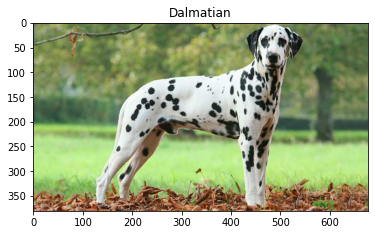

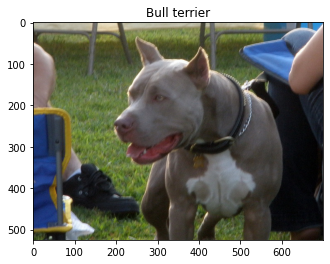

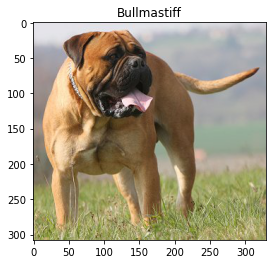

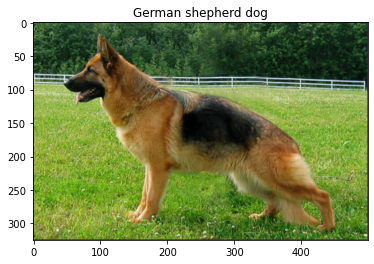

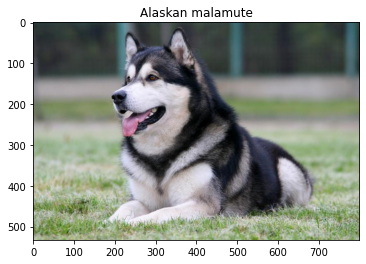

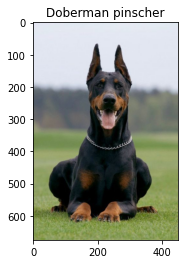

In [118]:
for i in dog_images:
  predict_breed_transfer(i)